# Causal discovery For Time Series

## Granger Causality

### Libraries

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import LinearRegression
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.tsatools import lagmat2ds
from sklearn.metrics import mean_squared_error as mse

warnings.filterwarnings("ignore")
plt.style.use('seaborn')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Dataset

**The user need to specify a dataset to work on**

In this part, we create a Toy Dataset where x and y are time dependent. We see here that x is causing y. In fact, we have $ y_t = 2x_{t-1} + x_{t-2}$

In [ ]:
x = [np.cos(k) for k in range(102)]
y = [x[k] + 2*x[k+1] for k in range(100)]
x = x[2:]
dataset = pd.DataFrame({'Time Serie1':x,'Time Serie2':y})

NameError: ignored

In [ ]:
x = [np.random.normal() for k in range(102)]
y = [2*x[k+1] for k in range(100)]
x = x[2:-2]
y = y[2:]
dataset = pd.DataFrame({'Time Serie1':y,'Time Serie2':x})

In [ ]:
dataset

,Time Serie1,Time Serie2
0,-0.339781,1.152888
1,0.576444,2.366146
2,1.183073,-1.093229
3,-0.546614,0.589789
4,0.294895,0.758785
...,...,...
93,-1.186155,-1.690762
94,-0.845381,-0.169555
95,-0.084778,1.452172
96,0.726086,-1.037185


In [ ]:
dataset = pd.concat(flds,axis=0)

In [ ]:
dataset = dataset.loc[:,["TI1105.PV","TC1124.PV"]].iloc[:,:]

**Show the head of the dataset to see what the data look like**

In [ ]:
dataset.head()

,TI1105.PV,TC1124.PV
1640,356.714630,139.894608
1641,356.770264,139.917862
1642,356.706726,140.000931
1643,356.643188,140.099380
1644,356.223755,140.126648


**Plot 100 time steps to have a visualisation of the data**

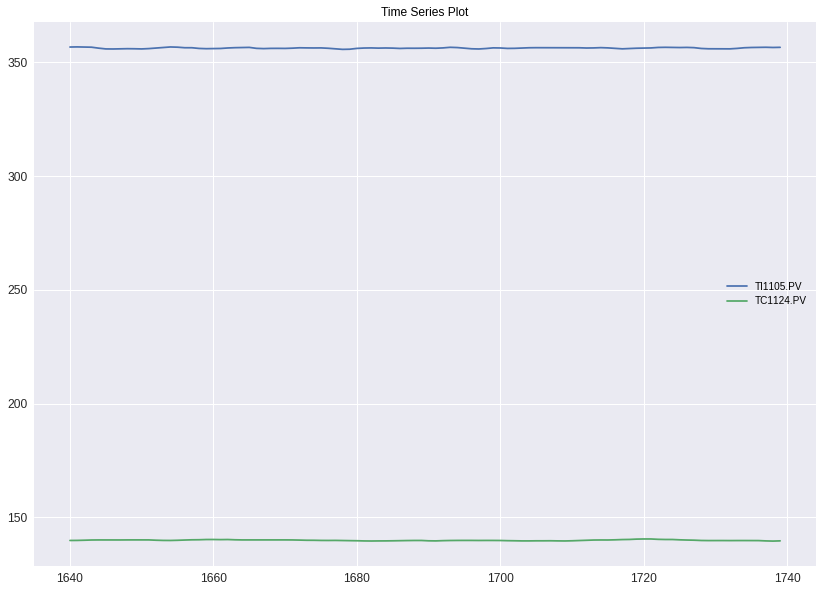

In [ ]:
dataset.iloc[:,].plot(figsize = (14,10), title = "Time Series Plot")
plt.show()

### Stationarity test

**In this section, the user will check if his data is stationary**


We use different tests: The Augmented Dickey Fuller test (ADF test) and the Kwiatkowski-Phillips-Schmidt-Shin – (KPSS test).

Let apply the stationarity test on the following time serie

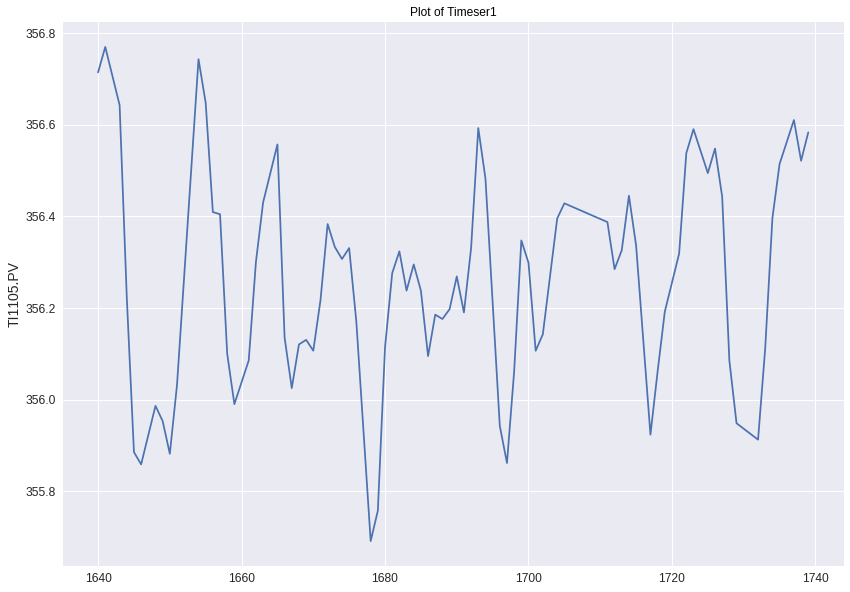

In [ ]:
ax = dataset.iloc[:100,0].plot(figsize = (14,10), title = "Plot of Timeser1")
ax.set_ylabel(dataset.iloc[:100,0].name)
plt.show()

The next cell code imports the statistical tests from the package statsmodels

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss



The most popular stationarity test is the ADF test where the null hypothesis states that the time serie is not stationary and possesses a unit root.

In the KPSS test, the null hypothesis states that the time serie is stationary.

If the p-value of the tests is less than the significance level (0.05), we reject the hypothesis.

In hypothesis testing, a critical value is a point on the test distribution that is compared to the test statistic to determine whether to reject the null hypothesis. If the absolute value of your test statistic is greater than the critical value, you can declare statistical significance and reject the null hypothesis.

In [ ]:
# ADF Test
result = adfuller(dataset.iloc[:100,0].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


# KPSS Test
result = kpss(dataset.iloc[:100,0].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -6.385671105189359
p-value: 2.16736458188668e-08

KPSS Statistic: 0.167171
p-value: 0.100000


In [ ]:
result = adfuller(dataset.iloc[:100,0].values, maxlag=30,autolag=None)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'nlag: {result[2]}')

ADF Statistic: -1.6820256573594043
p-value: 0.4403963795515077
nlag: 30


In [ ]:
def is_stationnary(series, signif=0.05, lag = None, diff = 0):
  """
  Function checking if the serie is stationnary

  Parameters
  ----------
  series : Pd.Series
      Time Series in a pd.Series format
  signif : float
      threshold for p-value
  lag : int
      number of lag to be chosen, None by default.
  diff : int
      number of difference to apply
  Returns
  -------
  list :
      [0]: Time Series
      [1]: Sentence
      [2]: p-value
      [3]: number of lag
      [4]: number of difference
  """
  series = pd.Series(series)
  d = 0
  if lag is None:
    result = adfuller(series, autolag='AIC')
    while result[1] > signif:
      series = series.diff().dropna()
      d += 1
      result = adfuller(series, autolag='AIC')
    if d > 0:
      sent = "The time series is stationnary with {l} lags chosen and {n} differences".format(n=d,l = result[2])
    else:
      sent = "The time series is stationnary with {l} lags".format(n=d,
                                                                l = result[2])
    return series,sent , result[1], result[2], d
  else:
    for k in range(diff):
      series = series.diff().dropna()
    result = adfuller(series, maxlag= lag, autolag=None)
    sent = "The time series is stationnary with {l} lags chosen and {n} differences".format(n=diff, l =result[2] )
    return series, sent, result[1], result[2], d

In [ ]:
y = [np.random.normal(10) for k in range(100)]
y = np.array(y) + np.array(range(len(y)))

In [ ]:
is_stationnary(dataset.iloc[:,0])

(1641    0.014282
 1642    0.014282
 1643    0.014252
 1644    0.014282
 1645    0.014282
           ...   
 1735   -0.011230
 1736    0.040832
 1737    0.040863
 1738    0.040863
 1739    0.040863
 Name: TI1126.PV, Length: 99, dtype: float64,
 'The time series is stationnary with 1 lags chosen and 1 differences',
 7.441879245130261e-08,
 1,
 1)

In [ ]:
is_stationnary(y)

(1     3.293322
 2     0.716555
 3     1.040587
 4    -2.232801
 5     4.012481
         ...   
 95    2.324123
 96    0.603216
 97   -0.891569
 98    2.675840
 99    0.111229
 Length: 99, dtype: float64,
 'The time series is stationnary with 6 lags chosen and 1 differences',
 1.828625848899173e-08,
 6,
 1)

In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [ ]:
# ADF Test on each column
for name, column in dataset.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "TI1126.PV" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6095
 No. Lags Chosen       = 2
 Critical value 1%     = -3.5
 Critical value 5%     = -2.892
 Critical value 10%    = -2.583
 => P-Value = 0.091. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "TI1127.PV" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.8949
 No. Lags Chosen       = 1
 Critical value 1%     = -3.499
 Critical value 5%     = -2.892
 Critical value 10%    = -2.583
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




  Si la série temporelle n'est pas stationnaire:

In [ ]:
# ADF Test on each column
for name, column in dataset.iteritems():
    adfuller_test(column.diff().dropna(), name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "TI1126.PV" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.1541
 No. Lags Chosen       = 1
 Critical value 1%     = -3.5
 Critical value 5%     = -2.892
 Critical value 10%    = -2.583
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "TI1127.PV" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.1183
 No. Lags Chosen       = 7
 Critical value 1%     = -3.504
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




The results of the test allows us to say that the data is stationary.

**Warning for the user if there is not stationarity**

### Granger Causality

**In this section, the user will compute Granger Causality and check if a time serie 1 "Granger Cause" a second Time Serie 2**

In 1969, Granger introduced the first concept of Causality in order to see whether one time series is useful in forecasting another.

**Definition**[Granger Causality]

  Time series $X$ "Granger causes" time series $Y$ if the future value of  $Y$ (at time $t+1$) can be better predicted by using both the values of $X$ and $Y$ up to time t than by using only the past values of $Y$ itself.


The next cell code imports the granger test from the package statsmodels

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

implemented in the stats model package

The function grangertests takes as input a 2D array with the 2 time series that we want to test, the predictor is the second column.

The Null hypothesis of the test states that the time serie in the second column does not Granger cause the first. If the P-Values are less than a significance level (0.05) then we reject the null hypothesis and conclude that the second time serie X is usefull and granger cause Y

The second argument maxlag says till how many lags of Y should be included in the test.

In [ ]:
print(grangercausalitytests(dataset, maxlag=4))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=25.5994 , p=0.0000  , df_denom=96, df_num=1
ssr based chi2 test:   chi2=26.3994 , p=0.0000  , df=1
likelihood ratio test: chi2=23.4020 , p=0.0000  , df=1
parameter F test:         F=25.5994 , p=0.0000  , df_denom=96, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=17.4094 , p=0.0000  , df_denom=93, df_num=2
ssr based chi2 test:   chi2=36.6908 , p=0.0000  , df=2
likelihood ratio test: chi2=31.1654 , p=0.0000  , df=2
parameter F test:         F=17.4094 , p=0.0000  , df_denom=93, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=12.4104 , p=0.0000  , df_denom=90, df_num=3
ssr based chi2 test:   chi2=40.1270 , p=0.0000  , df=3
likelihood ratio test: chi2=33.5811 , p=0.0000  , df=3
parameter F test:         F=12.4104 , p=0.0000  , df_denom=90, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=9.5116  , p=0.0000  , df_d

The algorithm output the results of the statistical tests depending on the number of lag we choose. The p-value allows us to conclude that for 1 lags, because it is higher than 0.05, there is granger causality

### Granger Causality Visualization

In [ ]:
class OLS_func():
    """ class for applying Granger causality with OLS """


    def __init__(self, dataset, lag = 1,split = 0.8):
        self.dataset = dataset
        self.lag = lag
        self.split = split

    def fit_ols(self):
      self.data = lagmat2ds(np.array(dataset), self.lag , trim="both", dropex=1)
      self.dataendog = add_constant(self.data [:, 1 : (self.lag + 1)], prepend=False)
      self.dataexog = add_constant(self.data [:, 1:], prepend=False)

      len_test = int((1-self.split)*len(self.data))
      self.ols_endog = OLS(self.data[:-len_test, 0], self.dataendog[:-len_test]).fit()
      self.ols_exog = OLS(self.data[:-len_test, 0], self.dataexog[:-len_test]).fit()

      pred1 = res2down.predict(dtaown[-len_test:])
      pred2 = res2djoint.predict(dtajoint[-len_test:])
      return pred1, pred2


In [ ]:
dataset = lagmat2ds(np.array(dataset), self.lag , trim="both", dropex=1)
dataendog = add_constant(self.dataset [:, 1 : (self.lag + 1)], prepend=False)
dataexog = add_constant(self.dataset [:, 1:], prepend=False)

len_test = int((1-self.split)*len(self.dataset))
self.ols_endog = OLS(self.dataset[:-len_test, 0], self.dataendog[:-len_test]).fit()
self.ols_exog = OLS(self.dataset[:-len_test, 0], self.dataexog[:-len_test]).fit()

pred1 = res2down.predict(dtaown[-len_test:])
pred2 = res2djoint.predict(dtajoint[-len_test:])

In [ ]:
dataset = pd.concat(flds,axis=0)

In [ ]:
dataset = dataset.loc[:,["TI1105.PV","TC1124.PV"]].iloc[:,:]

In [ ]:
dataset = pd.read_csv("eggs.csv").iloc[:,1:]

In [ ]:
lag = 1
dta = lagmat2ds(np.array(dataset), lag , trim="both", dropex=1)
dtaown = add_constant(dta[:, 1 : (lag + 1)], prepend=False)
dtajoint = add_constant(dta[:, 1:], prepend=False)

res2down = OLS(dta[:-20, 0], dtaown[:-20]).fit()
res2djoint = OLS(dta[:-20, 0], dtajoint[:-20]).fit()
res2down.params

array([0.9989514, 0.376616 ])

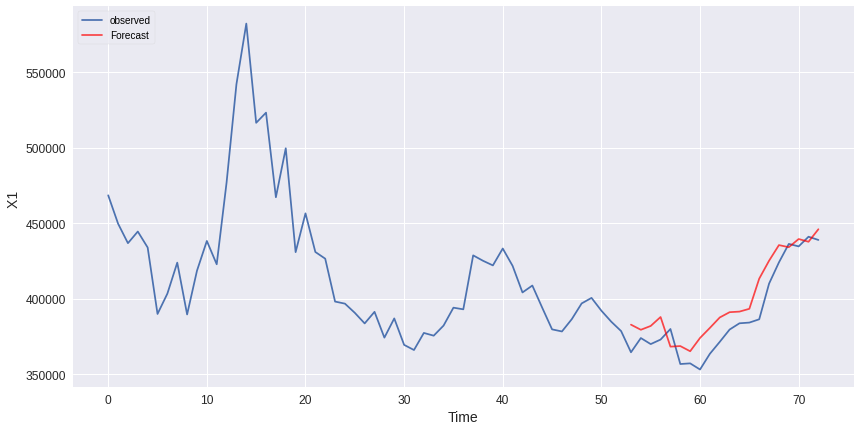

Prediction error using only past values of X1:  175674842.711263


In [ ]:
pred1 = res2down.predict(dtaown[-20:])
ax = pd.DataFrame(dta[:-1, 1]).rename(columns= {0: 'observed'}).plot()
pd.DataFrame(pred1).rename(columns= {0: 'Forecast'}).set_index(
    [pd.Index(range(len(dta)-21,len(dta)-1))]).plot(ax=ax, alpha=.7, figsize=(14, 7), color ='r')
ax.set_xlabel('Time')
ax.set_ylabel('X1 ')
plt.legend(loc = 2,frameon=True)
plt.show()

print("Prediction error using only past values of X1: ",
      mse(dta[-21:-1, 1],pred1[-20:]))

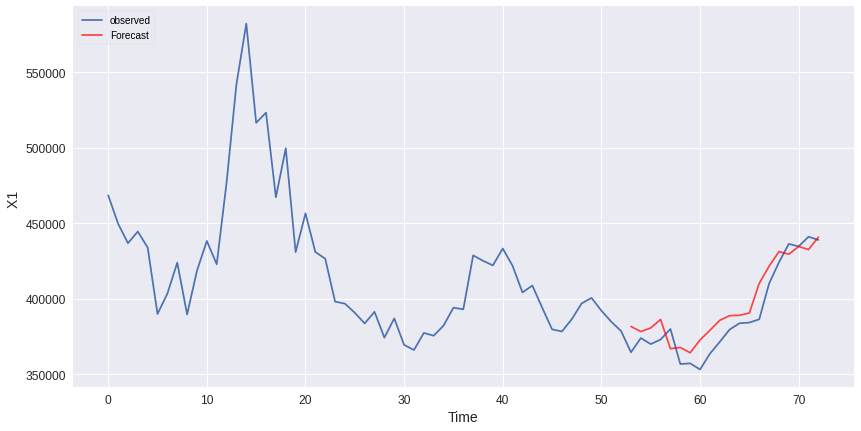

Prediction error using both past values of X1 and X2:  139405499.65335563


X2 Granger-Cause X1


In [ ]:
pred2 = res2djoint.predict(dtajoint[-20:])
ax = pd.DataFrame(dta[:-1, 1]).rename(columns= {0: 'observed'}).plot()
pd.DataFrame(pred2).rename(columns= {0: 'Forecast'}).set_index(
    [pd.Index(range(len(dta)-21,len(dta)-1))]).plot(ax=ax, alpha=.7,
                                                  figsize=(14, 7), color ='r')
ax.set_xlabel('Time')
ax.set_ylabel('X1 ')
plt.legend(loc = 2,frameon=True)
plt.show()

print("Prediction error using both past values of X1 and X2: ",
    mse(dta[-21:-1, 1],pred2[-20:]))

print("\n")

if mse(dta[-21:-1, 1],pred2) < mse(dta[-21:-1, 1],pred1):
    print("X2 Granger-Cause X1")
else:
  print("X2 doesn't Granger-Cause X1")

**The two plots allows the user to see that when we add the exogeneous variable, we can better fit the endogeneous variable, hence that there is Granger Causality**

### Test


In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
dta = lagmat2ds(np.array(dataset), lag , trim="both", dropex=1)

In [ ]:
dataset.head()

,chic,egg
0,468491,3581
1,449743,3532
2,436815,3327
3,444523,3255
4,433937,3156


In [ ]:
lag = 1
dta = lagmat2ds(np.array(dataset.iloc[:,[1,0]]), lag , trim="both", dropex=1)
dtaown = add_constant(dta[:, 1 : (lag + 1)], prepend=False)
dtajoint = add_constant(dta[:, 1:], prepend=False)


In [ ]:

res2down = LinearRegression()
res2down.fit( dtaown[:-20],dta[:-20, 0].reshape(-1,1))
print(res2down.coef_)
res2djoint = LinearRegression()
res2djoint.fit( dtajoint[:-20],dta[:-20, 0].reshape(-1,1))
res2djoint.coef_

[[0.96263218 0.        ]]


array([[ 9.61427301e-01, -1.17904186e-04,  0.00000000e+00]])

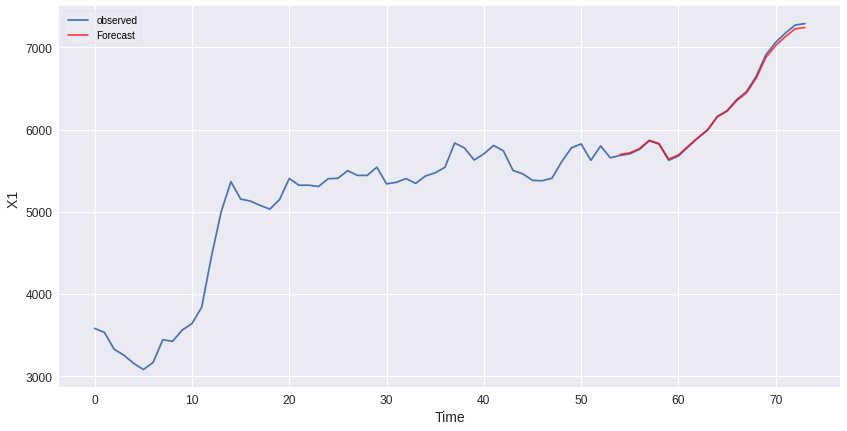

Prediction error using only past values of X1:  19339.78412022742


In [ ]:
pred1 = res2down.predict(dtaown[-20:])
ax = pd.DataFrame(dta[:, 1]).rename(columns= {0: 'observed'}).plot()
pd.DataFrame(pred1).rename(columns= {0: 'Forecast'}).set_index(
    [pd.Index(range(len(dta)-20,len(dta)))]).plot(ax=ax, alpha=.7, figsize=(14, 7), color ='r')
ax.set_xlabel('Time')
ax.set_ylabel('X1 ')
plt.legend(loc = 2,frameon=True)
plt.show()

print("Prediction error using only past values of X1: ",
      mse(dta[-20:, 0],pred1[-20:]))

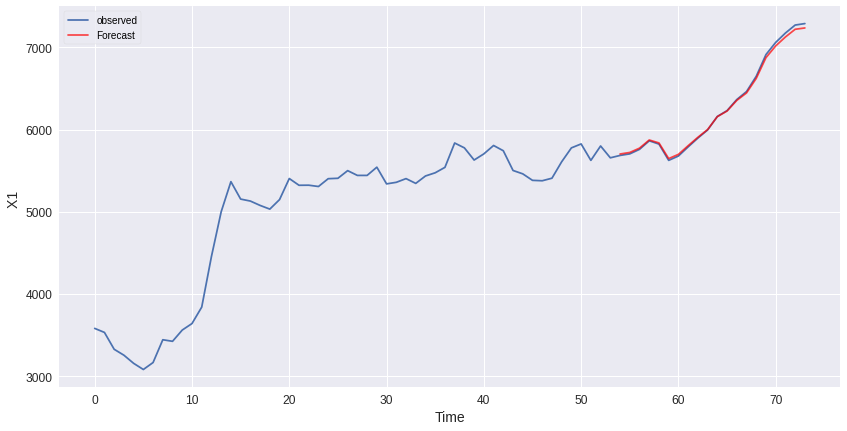

Prediction error using both past values of X1 and X2:  19561.100486393218


X2 doesn't Granger-Cause X1


In [ ]:
pred2 = res2djoint.predict(dtajoint[-20:])
ax = pd.DataFrame(dta[:, 1]).rename(columns= {0: 'observed'}).plot()
pd.DataFrame(pred2).rename(columns= {0: 'Forecast'}).set_index(
    [pd.Index(range(len(dta)-20,len(dta)))]).plot(ax=ax, alpha=.7,
                                                  figsize=(14, 7), color ='r')
ax.set_xlabel('Time')
ax.set_ylabel('X1 ')
plt.legend(loc = 2,frameon=True)
plt.show()

print("Prediction error using both past values of X1 and X2: ",
    mse(dta[-20:, 0],pred2[-20:]))

print("\n")

if mse(dta[-20:, 0],pred2) < mse(dta[-20:, 0],pred1):
    print("X2 Granger-Cause X1")
else:
  print("X2 doesn't Granger-Cause X1")

## Case Crossover Design


1. **Case Crossover**

The Case-crossover design (Maclure 1991) is used in epidemiology to find the acute change across population and is widely used to find the causes of diseases. The idea is to compare a "control" period, far from the event with a "case" period, just preceding the event. The comparison will allow us to see the differences and the variables that could be reponsible of the event

The objective here is to apply it on time series.

2. **Odd Ratio in our case**

Odd Ratio is a measure of association between exposure and an outcome. \\
We decided to compute the Odd ratio for our problem supposing that a huge change in the data is associated with the event. \\

\medskip

$$
\begin{array}{l |c| r}

   & Event & No Event \\
  \hline
  Exposed  & a & b \\
  Unexposed & c & d \\
 \end{array}
$$

$$
\text{Odd Ratio} = \frac{\text{odd of event}}{\text{odd of non-event}} = \frac{ad}{bc}
$$


**Remark**:

If OR = 1, no association. If OR > 1: The exposure increase the odds of the event.
In a case crossover study, we use the Cochran-Mantel-Haenszel test to find the odd ratio but only for one variable at a time.


## Case Crossover


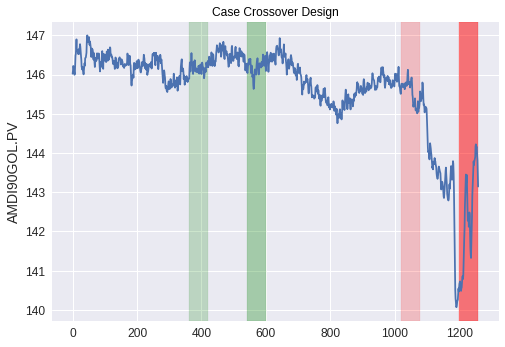

In the following we describe the class computing the Case-crossover Apriori algorithm:

1.   **The function MFL select a case or control periods and compute its mean, the user could choose one of them with the parameter c**
2.   **The function abs_dist is the metric used to compare the periods**
3. **The function compare allows to categorize the data by first applying the previous metric to a pair and then compare the given value with the threshold chosen by the user**
4. **Finallly, ARM_CC compute the Odd Ratio depending on choice of the control and case pair of periods**



In [ ]:

class Case_Cross :

    """ class for applying Case Crossover Design """


    def __init__(self,largeur, ecart_int, ecart_CC, dataset, comp = False,
                 threshold = [[0.6, 1]], num_val = 1200, num_control=1 ):
        self.data = dataset
        self.comp = comp
        self.threshold = threshold
        self.thresh = threshold[0]
        self.l = largeur
        self.e_int = ecart_int
        self.e_CC = ecart_CC
        self.num_val = num_val
        self.num_control = num_control

    def abs_dist(self,t):
        """
        Parameters
        ----------
        t : tuple
            contains value to compare.

        Returns
        -------
        absolute distance.

        """
        #return np.abs(t[1]-t[0]/t[1])
        #return np.abs((max(t)-min(t))/max(t))
        if max(t)==0:
            return 0
        return (np.abs(max(t))-np.abs(min(t)))/np.abs(max(t))


    def MFL(self,X):
        """
        Function comparing the mean of the control and case period
        Parameters
        ----------
        data : dataframe
            variable to study.
        comp: bool
            If False, we will have the case period, otherwise the control period
        c: int
            Choose a period, the bigger it is, the less distant from the event
            the period is

        Returns
        -------
        mean_control : list
            mean of the control period.
        mean_case : list
            mean of the case period.

        """
        # split dataset
        case1, case2 = X[-(1+self.l):-1],\
            X[-(1+self.e_int+2*self.l):-(1+self.e_int+self.l)]
        control1, control2 = X[-(1+self.l+self.e_CC+self.c):-(
            1+self.e_CC+self.c)],\
            X[-(1+self.e_int+2*self.l+self.e_CC+self.c):-(
                1+self.l+self.e_CC+self.c)]
        mean_case1 = case1.mean()
        mean_case2 = case2.mean()
        if self.comp:
            mean_control1 = control1.mean()
            mean_control2 = control2.mean()
            return mean_control1, mean_control2
        return mean_case1, mean_case2

    def compare(self):
        """
        Function comparing the events using a method and a treshold

        Parameters
        ----------
        method : func
            Method to use. ex: AR models
        thresh : float
            threshold on the value that we compare.
        comp : bool
            True if we want to compare the two control periods
        Returns
        -------
        count : Series
            Give the count of each variable that respected the thresh.
        df_flood : DataFrame
            Contain bool columns for each event telling which
            variable respeted the threshold
        """
        nb_flood = len(self.data)
        df = self.data[0].apply(self.MFL)
        col = df.apply(self.abs_dist)
        count = ((col>self.thresh[0])*1)&((col<=self.thresh[1])*1)
        column = [count.rename('flood_1')]
        for i in range(1,nb_flood):
            df = self.data[i].apply(self.MFL)
            col = df.apply(self.abs_dist)
            column.append((((col>self.thresh[0])*1)&((col<=self.thresh[1])*1)
            ).rename('flood_'+str(i+1)))
            count += column[-1]
        return count

    def ARM_CC(self):
      df_MFL = pd.DataFrame()
      num_evt = np.shape(self.data)[0]
      for i in range(self.num_control):
          self.c = int(i*(self.l/2))
          self.comp = True
          count_MFL = self.compare()
          #case-control comparison
          self.comp = False
          count_MFL_c = self.compare()
          df_MFL['case'+str(i)]  = count_MFL
          df_MFL['control'+str(i)] = count_MFL_c


          df_MFL['odd_ratio'+str(i)]= (df_MFL['case'+str(i)]+1) *(num_evt-
                                      df_MFL['control'+str(i)])/((num_evt-
                          df_MFL['case'+str(i)]) *(df_MFL['control'+str(i)]+1))
      df_MFL['case'] = df_MFL.filter(regex='^case',axis=1).mean(axis=1)
      df_MFL['control'] = df_MFL.filter(regex='^control',axis=1).mean(axis=1)
      df_MFL['odd_ratio'] = df_MFL.filter(regex='^odd_ratio',axis=1).mean(axis=1)
      return df_MFL.loc[:,['case','control','odd_ratio']]

### Class spliting the dataset and giving the default parameters depending on the dataset

In [ ]:
class param_def :

    """ class to split the dataset and get the parameters to apply the Case Crossover """


    def __init__(self, dataset, Y_name, X_name):
        self.data = None
        self.dataset = dataset
        self.target = Y_name
        self.X = X_name

    def get_lim(self):
        """
        Function to get minimum and maximum split length of the time series
        """
        #sort by length of time series
        column = pd.Series(self.dataset.loc[:,self.target])
        arg = np.argwhere((column.diff()==1).values).flatten()
        len_split = pd.Series(arg).diff().fillna(pd.Series(arg))
        val = len_split.sort_values().drop_duplicates()
        num_evt = 11
        i=0
        while num_evt >= 10 and i < len(val):
          lim_sup = val.iloc[i]
          num_evt = np.sum(len_split>=lim_sup)
          i+=1
        self.lim_sup = int(lim_sup)
        self.lim_inf = int(val.iloc[0])

    def split_data(self, len_ts=None):
        """
        Function to split the long time series dataset into events
        """
        df = []
        column = pd.Series(self.dataset.loc[:,self.target])
        arg = np.argwhere((column.diff()==1).values).flatten()
        len_split = pd.Series(arg).diff().fillna(pd.Series(arg))
        if len_ts == None:
            len_ts = self.lim_inf
        diff = arg[len_split>=len_ts]
        for val in diff:
            df.append(self.dataset.iloc[val-len_ts:val,:].loc[:,self.X].reset_index(drop=True))
        #Add mean at the end
        df_concat = pd.concat(df)
        by_row_index = df_concat.groupby(df_concat.index)
        df_means = by_row_index.mean()
        df.append(df_means)
        self.data = df

    def param_def(self):
      """
      Function to set the default parameters for the control and the case periods
      """
      length = np.shape(self.data)[1]
      self.largeur = int(length*0.05)
      self.ecart_int = int(length*0.05)
      self.ecart_CC = int(length*0.5)

### Main Function

In [ ]:

if __name__ == '__main__':


    #Define the parameters
    #Instanciate the class
    pdef = param_def( dataset, Y_name="FI",
                     X_name = list(dataset.columns[2:50]))

    #Get maximum and minimum limit of length split ( such that we have more than
    # 10 events, parameter for split data)
    pdef.get_lim()

    #split the dataset
    pdef.split_data()

    #get default parameters of the design
    #largeur, ecart_int, ecart_CC
    pdef.param_def()


    #Instanciate the method Case Crossover
    method = Case_Cross(largeur = pdef.largeur, ecart_int = pdef.ecart_int,
                        ecart_CC = pdef.ecart_CC, dataset = pdef.data,
                        comp = False,threshold = [[0.7, 1]],
                        num_val = np.shape(pdef.data)[-1], num_control= 3 )
    #Run the algorithm that output the table
    data_mfl =  method.ARM_CC()